# ARIMA and Seasonal ARIMA
### AutoRegression Integrated Moving Average
The general process for the ARIMA model is the following:
-- Visualizing the Time series data
-- Make the time series data stationary
-- Plot the correlation and AutoCorrelation charts
-- Construct the ARIMA and Seasonal ARIMA based on the data
-- Use the model to make predictions

Let's go through these steps!

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#importing machine learning libraries
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

#!pip install pmdarima
#install pmdarima library is not installed.
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings 
warnings.filterwarnings('ignore')

In [99]:
sales = pd.read_csv('Walmart.csv')
sales.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [100]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


### 1) Data Preprocessing

-- check null values
-- check duplicate rows
-- check invalid entries for each column.

In [101]:
# Check null values
sales.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

There are no null values in the sales-data provided

In [102]:
# check duplicate rows
sales[sales.duplicated()]

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment


There are no duplicate entries

In [103]:
# Check for invalid entries (can do it later)

#Store should not have negative values ... (do for other features)

### Feature engineering

-- Change Date to date_time
-- get the Year, month, day

In [104]:
sales['Date'] = pd.to_datetime(sales['Date'])
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


In [105]:
sales['Year'] = sales['Date'].dt.year
sales['Month'] = sales['Date'].dt.month
sales['Month_name'] = sales['Date'].dt.month_name()
sales['Week'] = sales['Date'].dt.week
sales.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Month_name,Week
0,1,2010-05-02,1643690.90,0,42.31,2.572,211.096358,8.106,2010,5,May,17
1,1,2010-12-02,1641957.44,1,38.51,2.548,211.242170,8.106,2010,12,December,48
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,2,February,7
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2010,2,February,8
4,1,2010-05-03,1554806.68,0,46.50,2.625,211.350143,8.106,2010,5,May,18


### 3) Exploratory Data Analysis

Here we exlore the given sales data, for walmart stores in-order to see the WeeklySales (target_value) for different features
-- Take one store to a new data-frame, and change the index to date

target_variable is Weekly_Sales
after each step write inference, then put conclusion for EDA also (useful to write conclusion). 

**Trend of the sales over time**
-- groupby Month, then sum(Weekly_sales) per month. (sales of Jan, sales of feb ...)
-- groupby year, then sum(weekly_sales) per year (sales on 2010, sales on 2011 ..)
-- groupby month, year then sum(weekly_sales) (sales on jan-2010, feb-2010, .. jan-2011, ...)

**Behaviour** of 5 features (individually) over Weekly_sales
-- groupby **Holiday_flag** (for 0 , 1 separetely) get sum(weekly_sales) or get boxplot for outliers
-- groupby range of **Temperature** (if min is 30, then 30-40, 40-50...) then see weekly_Sales
-- groupby **fuel_price** (see the histogram-distribution and range of fuel_price) (then range ike 2-3, 3-4 ..) then plot weekly_sales
-- groupby **CPI** ( you can take range wise as above), then plot the Weekly_sales
-- what is Consumer Price Index (CPI) ?
-- groupby **unemployment** (see the distribution whether its enum or random values, range as done for above features) then plot weekly_sales


**Store** wise distribution (groupby stores)
-- Weekly_sales for each store
[ get top 5 stores and bottom 5 stores (groupby **stores** and get the sum(weekly_sales)) ]

-- (Optional, to get an idea of feature dependency over sales) Get the correlation of each feature (5 features) (dont include Date) w.r.t weekly_sales , you can plot it for better inference

-- 
Number of Holiday_flags as one for each store (Store1 (count(Holiday_flag)), store2 (count(Holiday_flag)) ...)
Getting temperature distribution for each store(Store1 (temp range), store2 (temp range) ...)
Getting fuel_price distribution for each store
getting CPI distribution for each store
getting unemployment for each store

**Analysis of stores**:
If s1 is highest and s5 is least

why s5 is least?
-- see the 5 features, From the above behavior, 

why s1 is highest?
-- see the 5 features, From the above behavior,



#### Trend of the sales over time

In [106]:
# 1) Getting average_weekly_sales per Month
sales_per_month = sales.groupby('Month')['Weekly_Sales'].mean()
sales_per_month

Month
1     9.476139e+05
2     1.054597e+06
3     1.024975e+06
4     1.024324e+06
5     1.035379e+06
6     1.064848e+06
7     1.014212e+06
8     1.044874e+06
9     1.009457e+06
10    1.030631e+06
11    1.133751e+06
12    1.210255e+06
Name: Weekly_Sales, dtype: float64

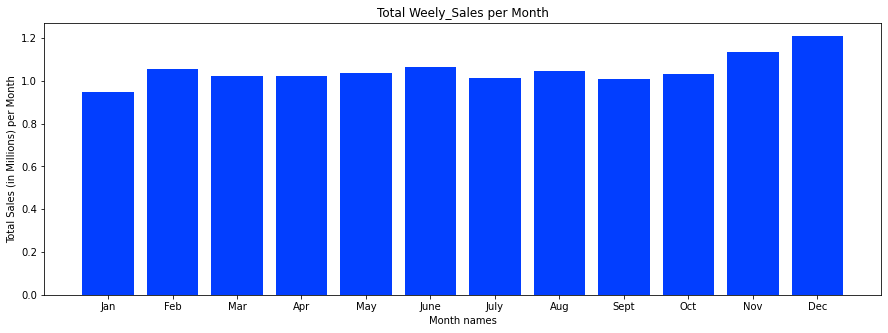

In [107]:
# Plotting the Monthly Sales
x_axis = sales_per_month.index
y_axis = sales_per_month.values/1e6
plt.figure(figsize=(15,5))
plt.bar(x_axis, y_axis);
plt.title('Total Weely_Sales per Month')
plt.xlabel('Month names')
plt.ylabel('Total Sales (in Millions) per Month')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12], ['Jan','Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']);

On November and December there are high sales compared to other days

In [108]:
# 2) Getting average_weekly_sales per Year

In [109]:
sales_per_month = sales.groupby('Year')['Weekly_Sales'].mean()
sales_per_month

Year
2010    1.059670e+06
2011    1.046239e+06
2012    1.033660e+06
Name: Weekly_Sales, dtype: float64

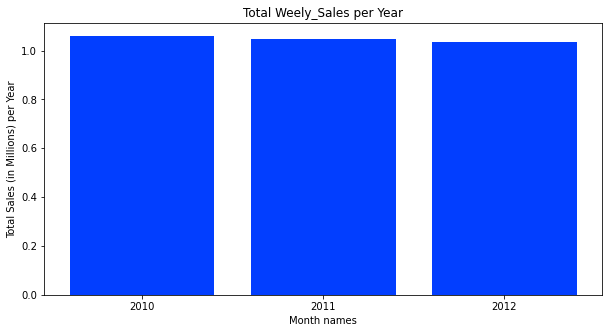

In [110]:
# Plotting the Yearly Sales
x_axis = sales_per_month.index
y_axis = sales_per_month.values/1e6
plt.figure(figsize=(10,5));
plt.bar(x_axis, y_axis);
plt.title('Total Weely_Sales per Year');
plt.xlabel('Month names');
plt.ylabel('Total Sales (in Millions) per Year');
plt.xticks(sales['Year'].unique());

There is no much difference in sales of 3 years, around 

In [111]:
# 3) Getting Monthly sales per year

In [112]:
pivot_table = sales.pivot_table(index='Month', columns='Year', values='Weekly_Sales')
pivot_table

Year,2010,2011,2012
Month,,,
1,9.386639e+05,9.420697e+05,9.567817e+05
2,1.064372e+06,1.042273e+06,1.057997e+06
3,1.034590e+06,1.011263e+06,1.025510e+06
4,1.021177e+06,1.033220e+06,1.014127e+06
5,1.039303e+06,1.015565e+06,1.053948e+06
6,1.055082e+06,1.038471e+06,1.082920e+06
7,1.023702e+06,9.976049e+05,1.025480e+06
8,1.025212e+06,1.044895e+06,1.064514e+06
9,9.983559e+05,1.026810e+06,9.988663e+05


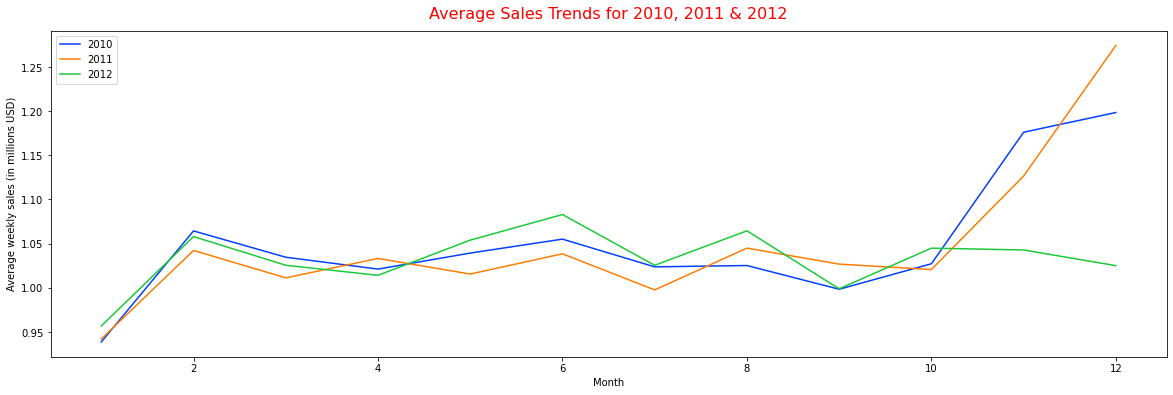

In [113]:
# 4) plot the average sales of Month (Year-wise)
fig, ax = plt.subplots(figsize=(20, 6))
sns.set_palette("bright")
sns.lineplot(x=pivot_table.index, y=pivot_table[2010]/1e6, ax=ax, label='2010')
sns.lineplot( x=pivot_table.index, y=pivot_table[2011]/1e6, ax=ax, label='2011')
sns.lineplot( x=pivot_table.index, y=pivot_table[2012]/1e6, ax=ax, label='2012')
plt.ylabel('Average weekly sales (in millions USD)')
plt.title('Average Sales Trends for 2010, 2011 & 2012', fontdict ={'fontsize':16,
                                                                   'color':'red',
                                                                   'horizontalalignment': 'center'},
                                                                   pad=12)
# Add a legend
plt.legend()
plt.show()

We can observe that the line charts for the three years for the month of January to October simultaneously follow a sawtooth shape with big rises experienced in November and December due to holidays. This indicates seasonality trends as months do have consistencies in bigger or smaller sales for the three years. We can also observe that although 2011 performed worst than 2010 in terms of average sales for Walmart, the trend was reversed for the year 2012 which performed better than 2010. However, the data for 2012 ends in October, which may explain the significant drop in sales for November."

#### Behaviour of 5 features (individually) over Weekly_sales

##### For Holidays as feature

Perform EDA
- Find the size/ shape of the data
- Check for invaid and null entries
- Explore data description (Done) (Getting Range, max, min distribution plot of each feature (5 features))
- Examine the correlation of the independent variables to the target variable (Weekly_Sales) (Done, for overall sales) *(Need to see for individual store)* 
- Line Plot of the effects of the independent features on the target varaible (Done, plotted for each featre (5 features) and inferred the results from it, for overall sales) *(Need to see for individual store)* 
- Box plot of the Features to identify the outiers (Need to do for other features) *(Not necessary that much bu still do it for overall sales)*


Text(0.5, 1.0, 'Distribution of Holidays in our sales data')

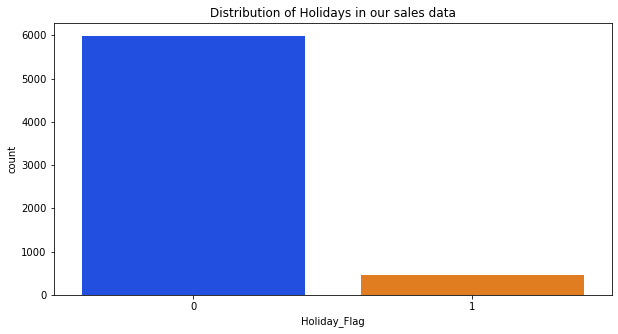

In [114]:
#Distribution of holidays over sales data
plt.figure(figsize=(10,5));
sns.countplot(sales['Holiday_Flag']);
plt.title('Distribution of Holidays in our sales data')

*For 45 stores, Around 450 days are Holidays and 5985 days are not holidays in our sales data.
Which means around 7% of our days are holidays for each store*

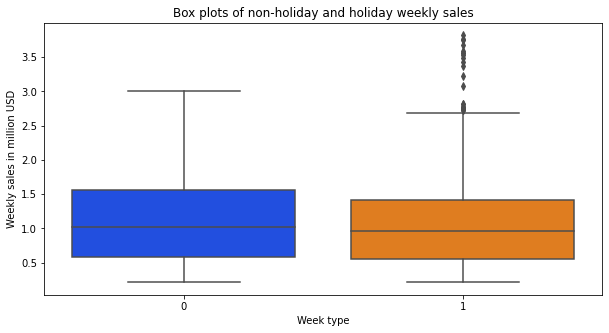

In [115]:
# filter out non-holiday and holiday weekly sales 
non_holiday_sales = sales[sales['Holiday_Flag'] == 0]
holiday_sales = sales[sales['Holiday_Flag'] == 1]

# plot box plots of non-holiday and holiday weekly sales 
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=[holiday_sales['Weekly_Sales']/1e6, non_holiday_sales['Weekly_Sales']/1e6])
plt.ylabel('Weekly sales in million USD')
plt.xlabel('Week type')
plt.title('Box plots of non-holiday and holiday weekly sales')
plt.show()

*We can see that both holiday and non-holiday weekly sales have similar spread. However, the bigger sales happen during the holiday weeks.*

##### For Temperature as feature

In [116]:
# Plot the distribution of the Temperature

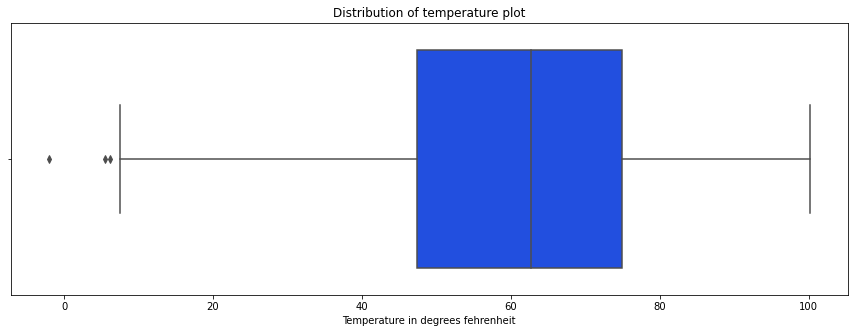

In [117]:
plt.figure(figsize=(15,5))
plt.title('Distribution of temperature plot')
sns.boxplot(sales['Temperature']);
plt.xlabel('Temperature in degrees fehrenheit');

Text(0.5, 1.0, 'Frequency distribution of Temperature in our sales data')

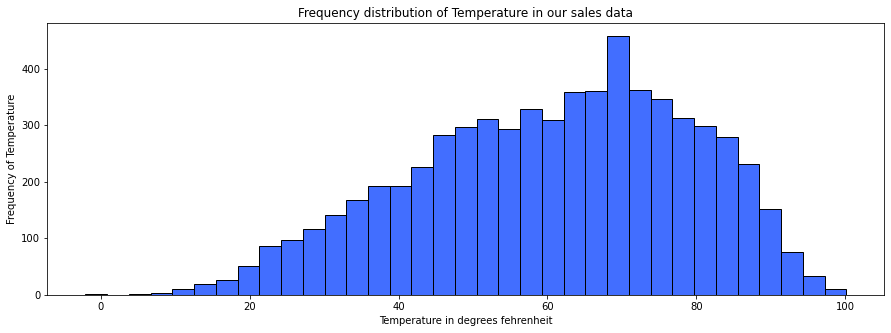

In [118]:
plt.figure(figsize=(15,5))
sns.histplot(sales['Temperature']);
plt.ylabel('Frequency of Temperature');
plt.xlabel('Temperature in degrees fehrenheit');
plt.title('Frequency distribution of Temperature in our sales data')

In [119]:
# geting weekly_sales for temperature distribution
sales['Temperature'].describe()

count    6435.000000
mean       60.663782
std        18.444933
min        -2.060000
25%        47.460000
50%        62.670000
75%        74.940000
max       100.140000
Name: Temperature, dtype: float64

*Majority of the temperature lies on 45 to 75 degrees Fehrenheit, with mean temperature value as 60*

In [120]:
# Distribution of weekly_sales over different temperature range
temp_range_list = np.arange(-5, 110, 5)
temperature_result={}
for lower_temp in temp_range_list:
    upper_temp = lower_temp + 5
    temperature_result['('+str(lower_temp)+'-'+str(upper_temp)+')']=sales[(sales['Temperature']>=lower_temp) & (sales['Temperature']<=upper_temp)]['Weekly_Sales'].mean()
print('Distribution of weekly_sales over different temperature range\n')
temperature_result

Distribution of weekly_sales over different temperature range



{'(-5-0)': 558027.77,
 '(0-5)': nan,
 '(5-10)': 860892.276,
 '(10-15)': 787501.3070833334,
 '(15-20)': 874629.6498214285,
 '(20-25)': 1021322.2571014499,
 '(25-30)': 1093330.1053968256,
 '(30-35)': 1147464.7458754873,
 '(35-40)': 1110590.0823197493,
 '(40-45)': 1101398.4156117025,
 '(45-50)': 1118047.0379032255,
 '(50-55)': 1056366.9686050722,
 '(55-60)': 1019458.5244444442,
 '(60-65)': 1054715.1006902657,
 '(65-70)': 1058188.2876737153,
 '(70-75)': 1049338.3846745568,
 '(75-80)': 1077432.6258500922,
 '(80-85)': 992458.5508789055,
 '(85-90)': 943308.025082417,
 '(90-95)': 867049.0274825174,
 '(95-100)': 546781.9563888889,
 '(100-105)': 289345.66500000004,
 '(105-110)': nan}

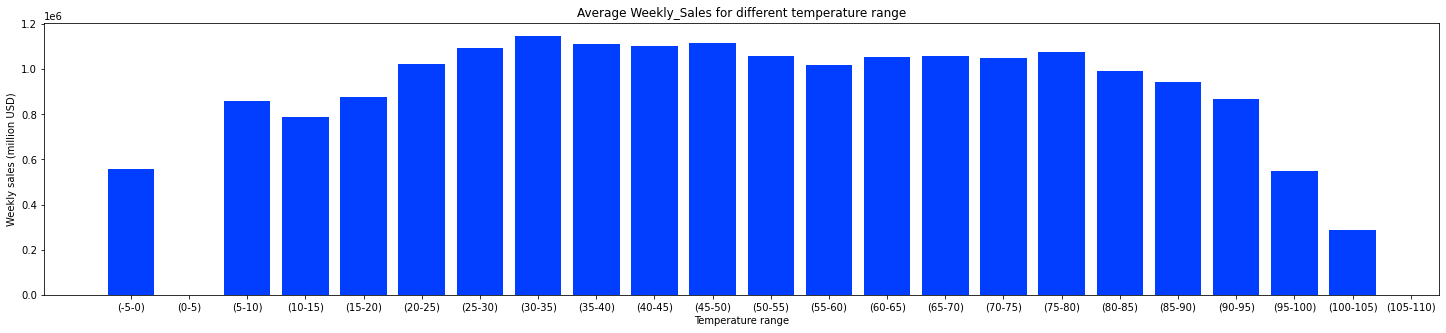

In [121]:
#plot of the weekly_sales over differen temperature ranges
plt.figure(figsize=(25,5));
plt.bar(temperature_result.keys(), temperature_result.values());
plt.title('Average Weekly_Sales for different temperature range');
plt.xlabel('Temperature range');
plt.ylabel('Weekly sales (million USD)');

*for temperature range of 20-80 (which is the majority frequency of temperature in our sales data), the sales is around 1.0 to 1.1 M USD.
The exception cases are when the temperature is in extreme ranges
Only for 
'(-5,0)': 0.8M USD, 
'(80-85)': 0.99M USD,
'(85-90)': 0.94M USD,
'(90-95)': 0.86M USD,
'(95-100)': 0.54M USD,
'(100-105)': 0.28M USD,*

##### For Fuel_Price as feature

Text(0.5, 1.0, 'Frequency Distribution of Fuel Price')

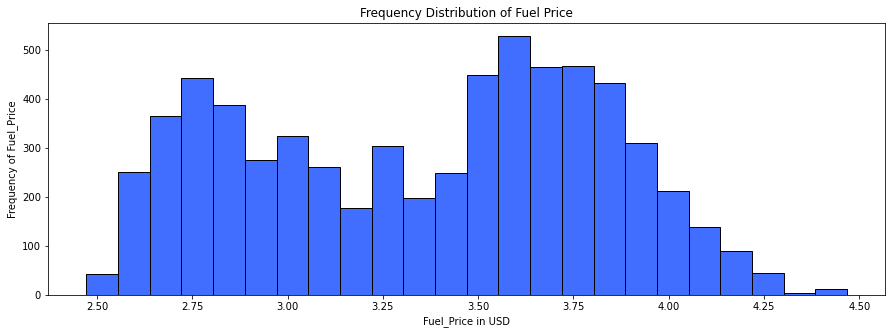

In [122]:
#plot the distribution of fuel_price
plt.figure(figsize=(15,5))
sns.histplot(sales['Fuel_Price']);
plt.title('Fuel Price distribution')
plt.ylabel('Frequency of Fuel_Price');
plt.xlabel('Fuel_Price in USD');
plt.title('Frequency Distribution of Fuel Price')

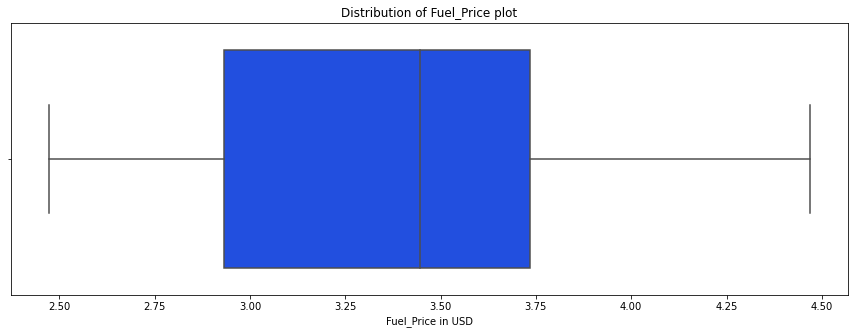

In [123]:
plt.figure(figsize=(15,5))
plt.title('Distribution of Fuel_Price plot')
sns.boxplot(sales['Fuel_Price']);
plt.xlabel('Fuel_Price in USD');

In [124]:
sales['Fuel_Price'].describe()

count    6435.000000
mean        3.358607
std         0.459020
min         2.472000
25%         2.933000
50%         3.445000
75%         3.735000
max         4.468000
Name: Fuel_Price, dtype: float64

*Majority of the Fuel_Price lies around 3.0 to 3.75*

In [125]:
# Distribution of weekly_sales over different fuel_price range
fuel_price_range_list = np.linspace(sales['Fuel_Price'].min(), sales['Fuel_Price'].max(), 10)
fuel_price_result={}
for i in range(0,len(fuel_price_range_list)-1):
    lower_fuel_price = round(fuel_price_range_list[i],2)
    upper_fuel_price = round(fuel_price_range_list[i+1],2)
    fuel_price_result['('+str(lower_fuel_price)+'-'+str(upper_fuel_price)+')']=sales[(sales['Fuel_Price']>=lower_fuel_price) & (sales['Fuel_Price']<upper_fuel_price)]['Weekly_Sales'].mean()
print('Distribution of weekly_sales over different Fuel_Price range\n')
fuel_price_result

Distribution of weekly_sales over different Fuel_Price range



{'(2.47-2.69)': 959595.0380616747,
 '(2.69-2.92)': 1063701.3225512935,
 '(2.92-3.14)': 1045542.3862849881,
 '(3.14-3.36)': 1079385.4158032765,
 '(3.36-3.58)': 1050823.7484566595,
 '(3.58-3.8)': 1041234.5761168114,
 '(3.8-4.02)': 1055160.8252451546,
 '(4.02-4.25)': 1068626.164858044,
 '(4.25-4.47)': 903126.7721052632}

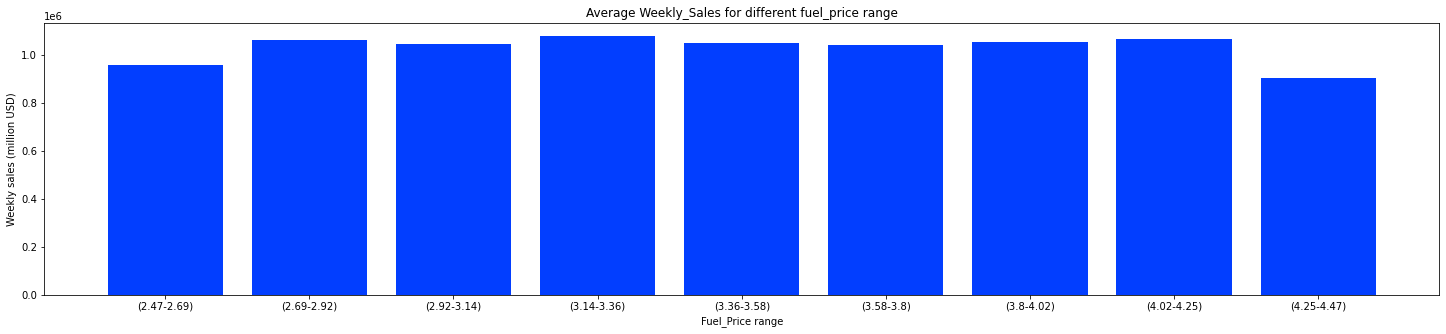

In [126]:
#plot of the weekly_sales over differen temperature ranges
plt.figure(figsize=(25,5));
plt.bar(fuel_price_result.keys(), fuel_price_result.values());
plt.title('Average Weekly_Sales for different fuel_price range');
plt.xlabel('Fuel_Price range');
plt.ylabel('Weekly sales (million USD)');

*There is not much variation in weekly_sales over Fuel_Price range it ranges around (1.04-1.08)M$. But in optimum temperature conditions the sales are at higher when compared to extreme conditions.*

##### For CPI as feature

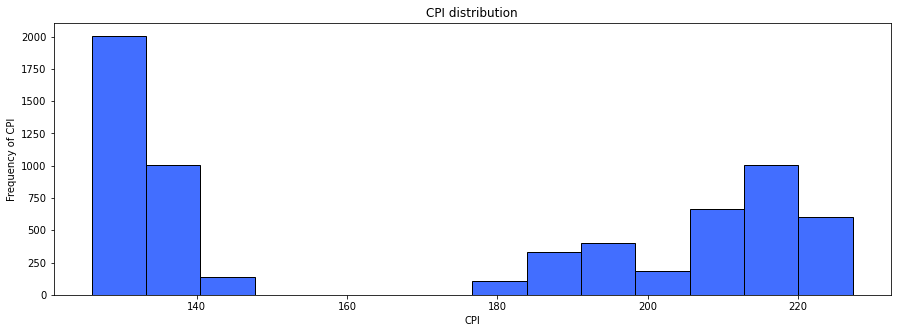

In [127]:
#plot the distribution of CPI
plt.figure(figsize=(15,5))
sns.histplot(sales['CPI']);
plt.title('CPI distribution')
plt.ylabel('Frequency of CPI');
plt.xlabel('CPI');

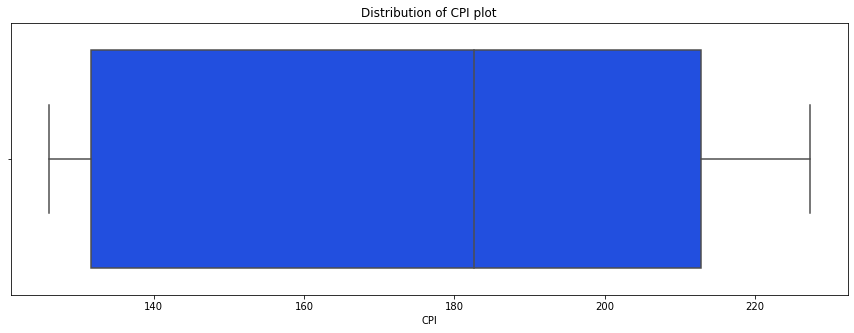

In [128]:
plt.figure(figsize=(15,5))
plt.title('Distribution of CPI plot')
sns.boxplot(sales['CPI']);
plt.xlabel('CPI');

In [129]:
sales['CPI'].describe()

count    6435.000000
mean      171.578394
std        39.356712
min       126.064000
25%       131.735000
50%       182.616521
75%       212.743293
max       227.232807
Name: CPI, dtype: float64

*Majority of CPI distribution lies in 130 to 140 (approx.) in our sales data, However there is few distribution of CPI around 180-220 (few in count) . With mean value as 171.5*

In [130]:
# Distribution of weekly_sales over different CPI range
CPI_range_list = np.linspace(sales['CPI'].min(), sales['CPI'].max(), 10)
CPI_result={}
for i in range(0,len(CPI_range_list)-1):
    lower_CPI = round(CPI_range_list[i],2)
    upper_CPI = round(CPI_range_list[i+1],2)
    CPI_result['('+str(lower_CPI)+'-'+str(upper_CPI)+')']=sales[(sales['CPI']>=lower_CPI) & (sales['CPI']<upper_CPI)]['Weekly_Sales'].mean()
print('Distribution of weekly_sales over different CPI range\n')
CPI_result

Distribution of weekly_sales over different CPI range



{'(126.06-137.3)': 1076164.2724325354,
 '(137.3-148.55)': 1114857.181829709,
 '(148.55-159.79)': nan,
 '(159.79-171.03)': nan,
 '(171.03-182.27)': 1486971.9400000004,
 '(182.27-193.51)': 1089674.1918545444,
 '(193.51-204.75)': 972155.0172750646,
 '(204.75-215.99)': 1012853.291953419,
 '(215.99-227.23)': 965871.4234458077}

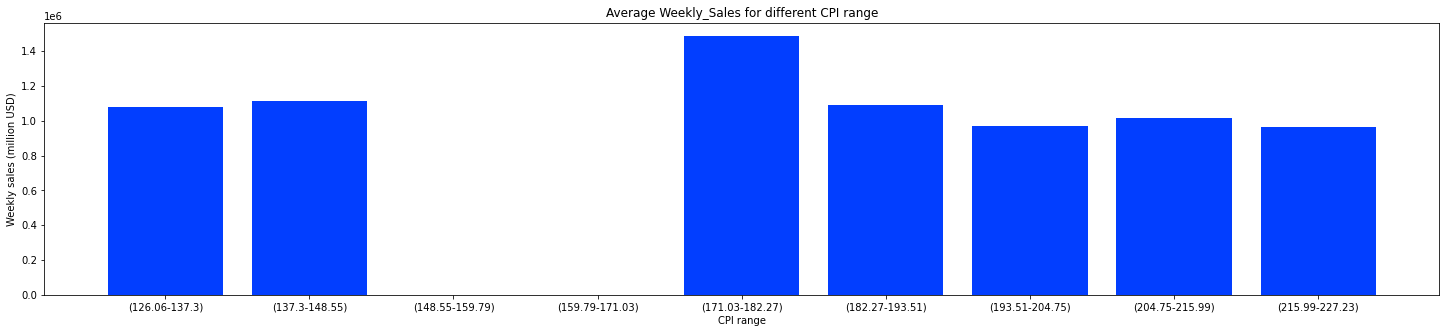

In [131]:
#plot of the weekly_sales over differen CPI ranges
plt.figure(figsize=(25,5));
plt.bar(CPI_result.keys(), CPI_result.values());
plt.title('Average Weekly_Sales for different CPI range');
plt.xlabel('CPI range');
plt.ylabel('Weekly sales (million USD)');

*Only in case of CPI range (approx.) (171-182) Weekly_sales is highest with 1.48M USD, for rest of the cases weekly sales is round 1M USD. The least is weekly_sales value is from (215-227) as 0.96M USD*

##### For Unemployment as feature

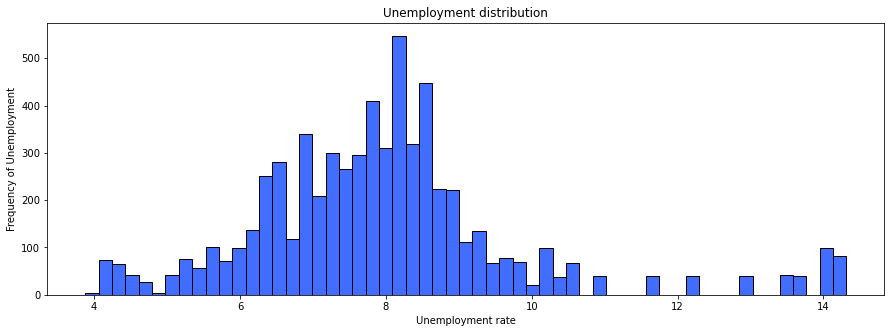

In [132]:
#plot the distribution of CPI
plt.figure(figsize=(15,5))
sns.histplot(sales['Unemployment']);
plt.title('Unemployment distribution')
plt.ylabel('Frequency of Unemployment');
plt.xlabel('Unemployment rate');

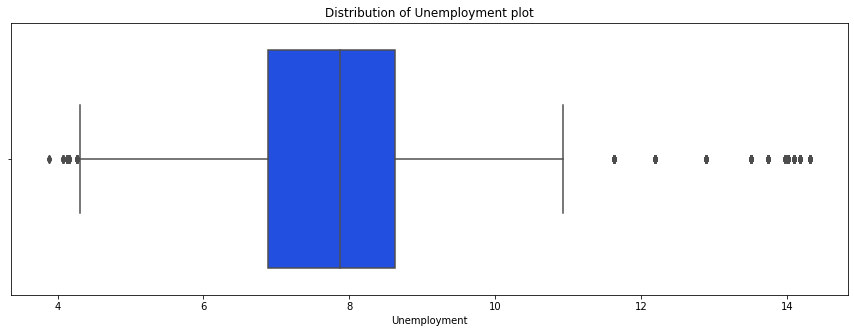

In [133]:
plt.figure(figsize=(15,5))
plt.title('Distribution of Unemployment plot')
sns.boxplot(sales['Unemployment']);
plt.xlabel('Unemployment');

In [134]:
sales['Unemployment'].describe()

count    6435.000000
mean        7.999151
std         1.875885
min         3.879000
25%         6.891000
50%         7.874000
75%         8.622000
max        14.313000
Name: Unemployment, dtype: float64

Majority of the Unemployment distribution lies in 6.9 to 8.6 with mean value as 8.0 (approx.)

In [135]:
# Distribution of weekly_sales over different Unemployment range
Unemployment_range_list = np.linspace(sales['Unemployment'].min(), sales['Unemployment'].max(), 10)
Unemployment_result={}
for i in range(0,len(Unemployment_range_list)-1):
    lower_Unemployment = round(Unemployment_range_list[i],2)
    upper_Unemployment = round(Unemployment_range_list[i+1],2)
    Unemployment_result['('+str(lower_Unemployment)+'-'+str(upper_Unemployment)+')']=sales[(sales['Unemployment']>=lower_Unemployment) & (sales['Unemployment']<upper_Unemployment)]['Weekly_Sales'].mean()
print('Distribution of weekly_sales over different Unemployment range\n')
Unemployment_result

Distribution of weekly_sales over different Unemployment range



{'(3.88-5.04)': 1361415.4465550233,
 '(5.04-6.2)': 1036757.1242883549,
 '(6.2-7.36)': 1010494.4504746415,
 '(7.36-8.52)': 1118604.0922787485,
 '(8.52-9.68)': 1028238.7198261673,
 '(9.68-10.84)': 716650.6221088435,
 '(10.84-11.99)': 893970.6698717949,
 '(11.99-13.15)': 971108.2746153843,
 '(13.15-14.31)': 882680.8783105016}

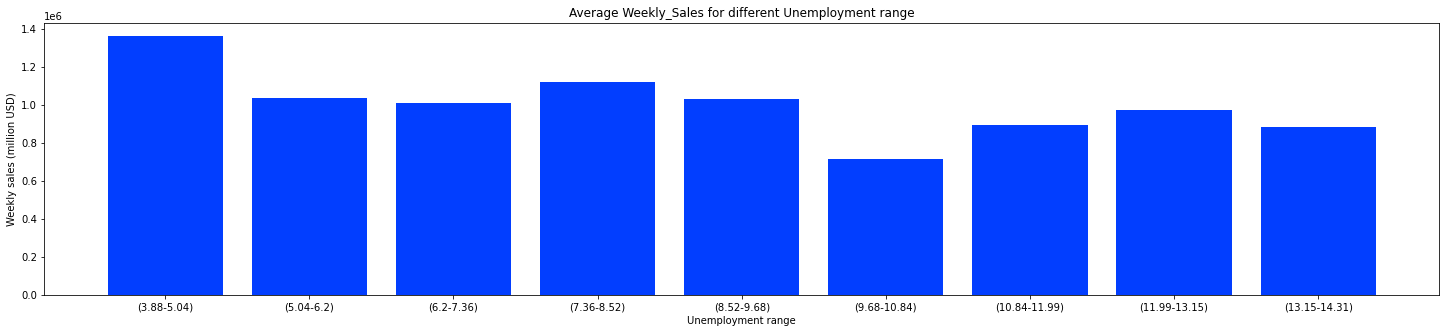

In [136]:
#plot of the weekly_sales over differen Unemployment ranges
plt.figure(figsize=(25,5));
plt.bar(Unemployment_result.keys(), Unemployment_result.values());
plt.title('Average Weekly_Sales for different Unemployment range');
plt.xlabel('Unemployment range');
plt.ylabel('Weekly sales (million USD)');

Here majority of the Unemployment Distribution count in our sales data lies around 8.0, and For lower unemployment rate, there is higher sales (1.4 M USD) when compared to higher unemployment rate(1.02 M USD for 9.0 unemployment and 0.7 M USD for 10.0 unemployment)

####  Overall correlations between the features of the dataset and weekly_sales

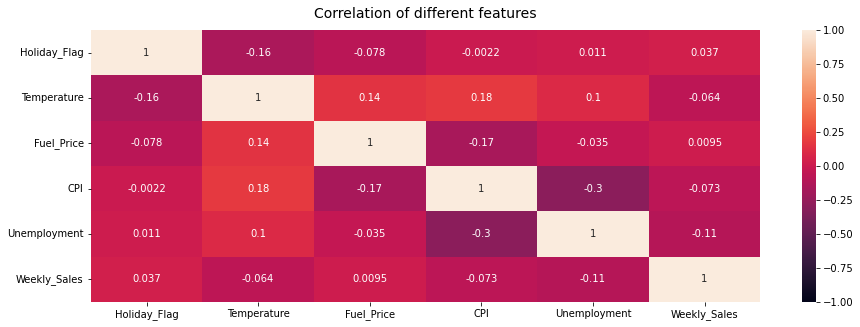

In [137]:
sales_corr = sales[['Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Weekly_Sales']]
plt.figure(figsize=(15,5))
heatmap = sns.heatmap(sales_corr.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation of different features', fontdict={'fontsize':14}, pad=12);

In [138]:
sales_corr.corr()['Weekly_Sales']

Holiday_Flag    0.036891
Temperature    -0.063810
Fuel_Price      0.009464
CPI            -0.072634
Unemployment   -0.106176
Weekly_Sales    1.000000
Name: Weekly_Sales, dtype: float64

Conclusion of correlation of features over Weekly_sales:
    
After correlation of overall Weekly_sales we can say that, 
Holiday_Flag    Has less significance ver weekly_sales, but we saw that for Holidays weekly_sales grows significantly high
Temperature    Here Weekly_Sales decreases over increase in temperature
Fuel_Price      It has Very less significance on weekly_sales , however weekly_sales increases upon increase in fuel_price
CPI            Here Weekly_Sales decreases over increase in temperature
Unemployment   : It has relatively higher significance (when compared to other features) on weekly_sales and it decreases upon increase in uneployment

### Conclusion of each Feature dependency on Weekly_Sales

**Holiday_Flag** : 
-- Around 450 days are Holidays and 5985 days are not holidays in our sales data. WHich means around 7% of our days are holidays

-- We can see that both holiday and non-holiday weekly sales have similar spread. However, the bigger sales happen during the holiday weeks.

**Temperature** : 
-- Majority of the temperature lies on 45 to 75 degrees Fehrenheit, with mean temperature value as 60
-- for temperature range of 20-80 (which is the majority frequency of temperature in our sales data), the sales is around 1.0 to 1.1 M$.
The exception cases are when the temperature is in extreme ranges only for 

'(-5,0)': 0.8M USD , 
'(80-85)': 0.99M USD,
'(85-90)': 0.94M USD,
'(90-95)': 0.86M USD,
'(95-100)': 0.54M USD,
'(100-105)': 0.28M USD,

**Fuel_Price** : 
-- Majority of the Fuel_Price lies around 3.0 to 3.75
-- There is not much variation in weekly_sales over Fuel_Price range it ranges around (1.04-1.08)M$. BUt in optimum temperature conditions the sales are at higher when compared to extreme conditions.

**CPI** : 
-- Majority of CPI distribution lies in 130 to 140 (approx.) in our sales data, However there is few distribution of CPI around 180-220 (few in count) . With mean value as 171.5
-- Only in case of CPI range (approx.) (171-182) Weekly_sales is highest with 1.48M USD, for rest of the cases weekly sales is round 1M USD. The least is weekly_sales value is from (215-227) as 0.96M USD

**Unemployment** : 
-- Majority of the Unemployment distribution lies in 6.9 to 8.6 with mean value as 8.0 (approx.)
-- Here majority of the Unemployment Distribution count in our sales data ies around 8.0, and For lower unemployment rate, there is higher sales (1.4M USD) 
when compared to higher unemployment rate(1.02M USD for 9.0 unemployment and 0.7M USD for 10.0 unemployment)

#### Store wise distribution (groupby stores)

**5. Which stores had the highest and lowest average revenues over the years?**

Identifying the top performing and low performing stores or products in sales analysis can be useful for a variety of purposes. By analysing the sales data for different stores, businesses can identify opportunities for growth, understand customer preferences, optimise inventory levels, and identify potential problems or areas for improvement. Understanding the performance of different stores  can inform product development and marketing efforts, as well as help businesses allocate resources more effectively and make more informed business decisions.

We will create a function that takes a dataframe as input and generates two plots showing the top and bottom performing stores in terms of average sales.

In [139]:
def plot_top_and_bottom_stores(df, col):
    """
    Plot the top and bottom 5 stores based on their average weekly sales.
    
    Parameters:
    df (pandas DataFrame): The dataframe containing the sales data.
    col (str): The name of the column to group the data by.
    
    Returns:
    None
    """
    # Group the data by the specified column and sort it by sales in descending order
    df = df.groupby(col).mean().sort_values(by='Weekly_Sales', ascending=False)
    
    # Select the top 5 and bottom 5 products
    top_stores = df.head(10)
    bottom_stores = df.tail(10)
    
    # Set the color palette
    sns.set_palette("bright")
    
    # Create a bar chart of the top 5 products
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x=top_stores.index, y=top_stores['Weekly_Sales']/1e6, order=top_stores.index)
    plt.title('Top 10 Stores by Average Sales')
    plt.ylabel('Average weekly sales (millions USD)')
    plt.show()
    
    # Create a bar chart of the bottom 5 products
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x=bottom_stores.index, y=bottom_stores['Weekly_Sales']/1e6, order=bottom_stores.index)
    plt.title('Bottom 10 Stores by Average Sales')
    plt.ylabel('Average weekly sales (millions USD)')
    plt.show()


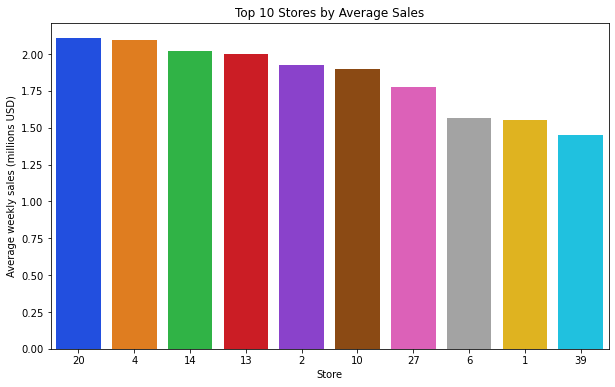

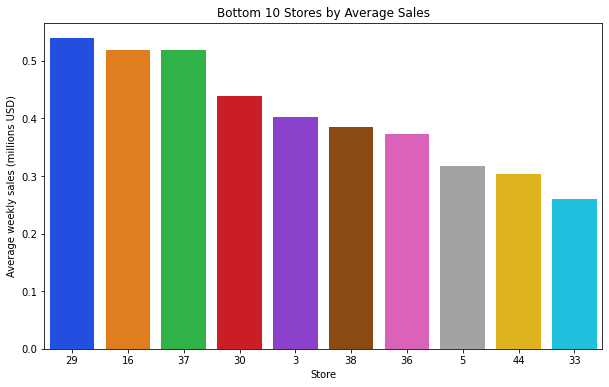

In [140]:
plot_top_and_bottom_stores(sales, 'Store')

The graphs show that the top performing stores have relatively stable sales with an average of around $2 million USD. Store 20 appears to be the top performer among these stores, with relatively little variation in sales compared to the other top performers.

On the other hand, the lowest performing stores have higher variations in sales, with the highest sales at around $0.38 million USD. This suggests that there may be more variability in the sales performance of these stores.

###  Correlation of 5 features on weekly_sales for different stores

- Correlation of Holiday_flag wih Weekly_Sales (for different stores) 
- Correlation of Temperature wih Weekly_Sales (for different stores) 
- Correlation of Fuel_Price wih Weekly_Sales (for different stores) 
- Correlation of CPI wih Weekly_Sales (for different stores) 
- Correlation of Unemployment wih Weekly_Sales (for different stores) 

In [141]:

store_corr = pd.DataFrame(index=['Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment'])
for i in range(1,46):
    store_df = sales[sales['Store']==i][['Weekly_Sales','Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']]
    store_corr[str(i)] = store_df.corr()['Weekly_Sales'].tolist()
store_corr=store_corr.T
store_corr.drop(columns=['Weekly_Sales'], inplace=True)
store_corr.head()

,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
1,0.194905,-0.222701,0.124592,0.225408,-0.097955
2,0.177726,-0.297673,-0.196375,-0.062431,0.066325
3,0.208556,-0.377524,0.140886,0.317250,-0.230413
4,0.153388,-0.225583,0.211549,0.351157,-0.337015
5,0.302525,-0.175517,0.167352,0.308261,-0.207043


In [142]:
def plot_corr_of_sales_on_diff_features(feature, store_corr):
    plt.figure(figsize=(15,5))
    store_corrT=store_corr.sort_values(by = feature)
    sns.barplot(x=store_corrT.index, y=store_corrT[feature]);
    plt.grid(True)
    plt.xlabel('Store numbers')
    plt.ylabel('Correlation of '+feature)
    plt.title('Correlation of Weekly_Sales with '+feature+' for differet stores')

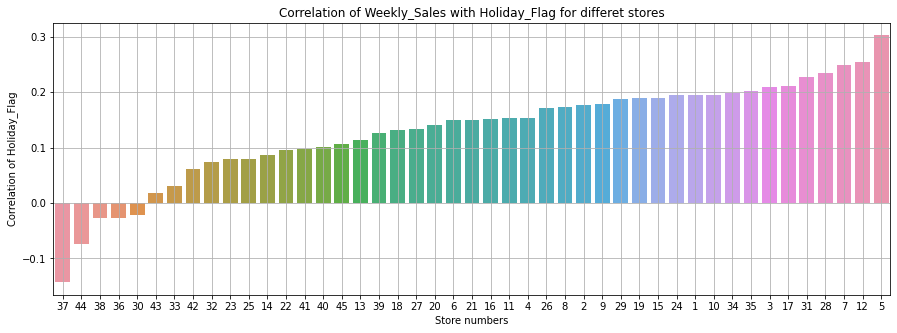

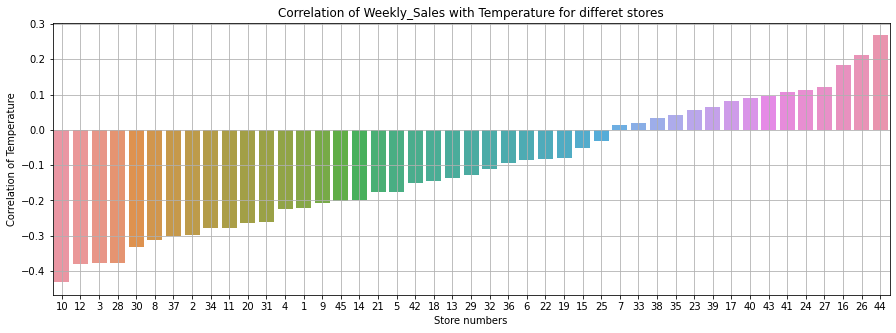

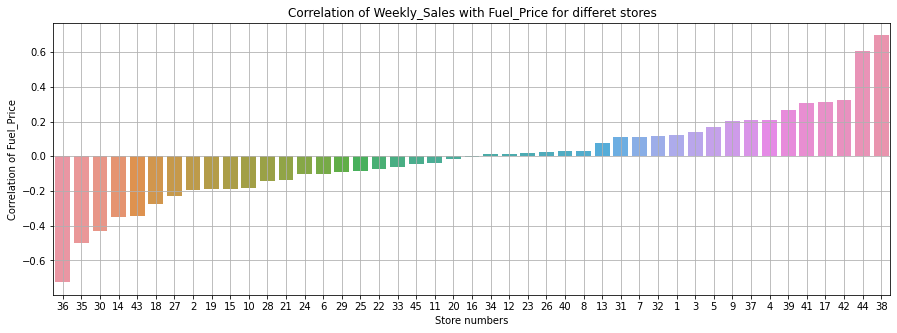

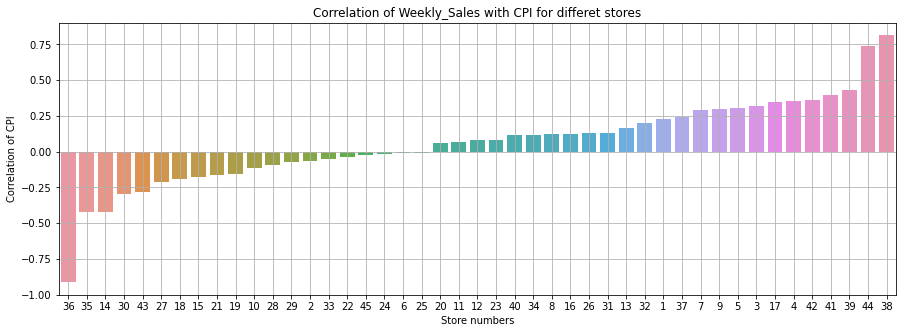

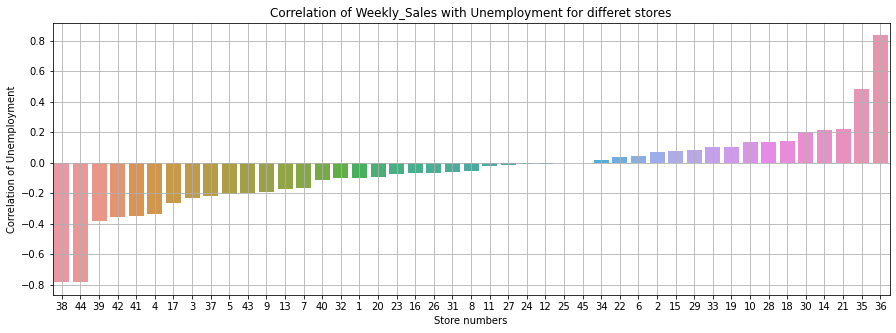

In [143]:
# plot the correlation for Holiday_flag vs Weekly_sales for different stores 
plot_corr_of_sales_on_diff_features('Holiday_Flag', store_corr)
plot_corr_of_sales_on_diff_features('Temperature', store_corr)
plot_corr_of_sales_on_diff_features('Fuel_Price', store_corr)
plot_corr_of_sales_on_diff_features('CPI', store_corr)
plot_corr_of_sales_on_diff_features('Unemployment', store_corr)

### Examine the outliers for each store

In [144]:
def outlier_plot(sales_range, l=5, w=2, lw=20, ww=10, hs=1.5):
    fig,axes=plt.subplots(l,w, figsize=(lw,ww))
    plt.subplots_adjust(hspace=hs)
    j=1
    for i in sales_range:
        store_df=sales[sales['Store']==i]
        plt.subplot(l,w,j)
        sns.boxplot(x=store_df['Weekly_Sales'])
        plt.title('Store '+str(i), fontsize=15)
        j+=1

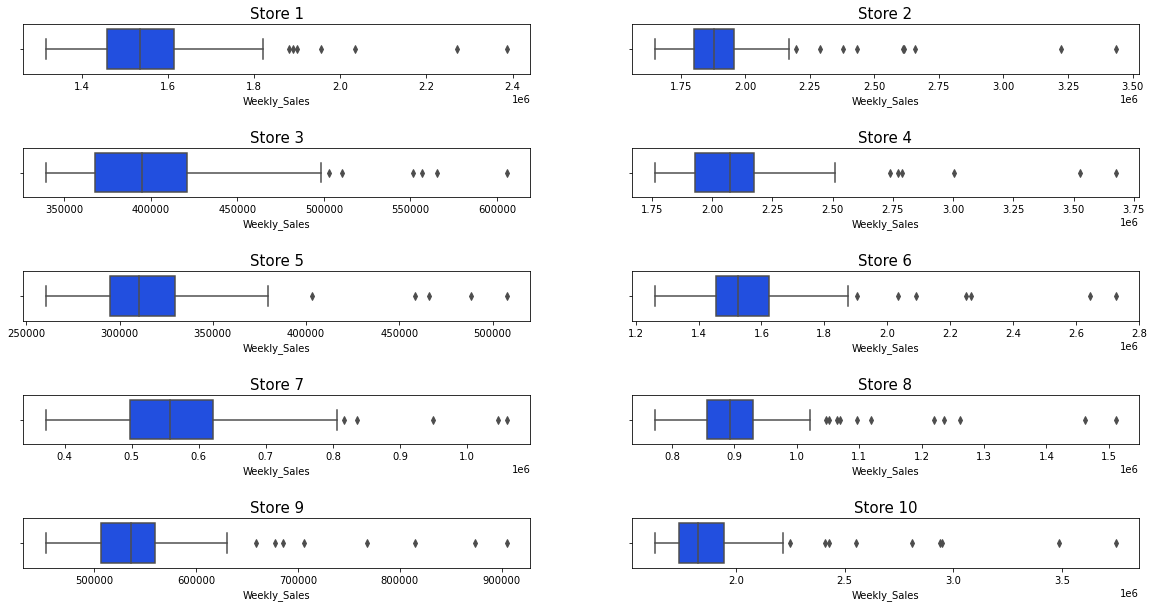

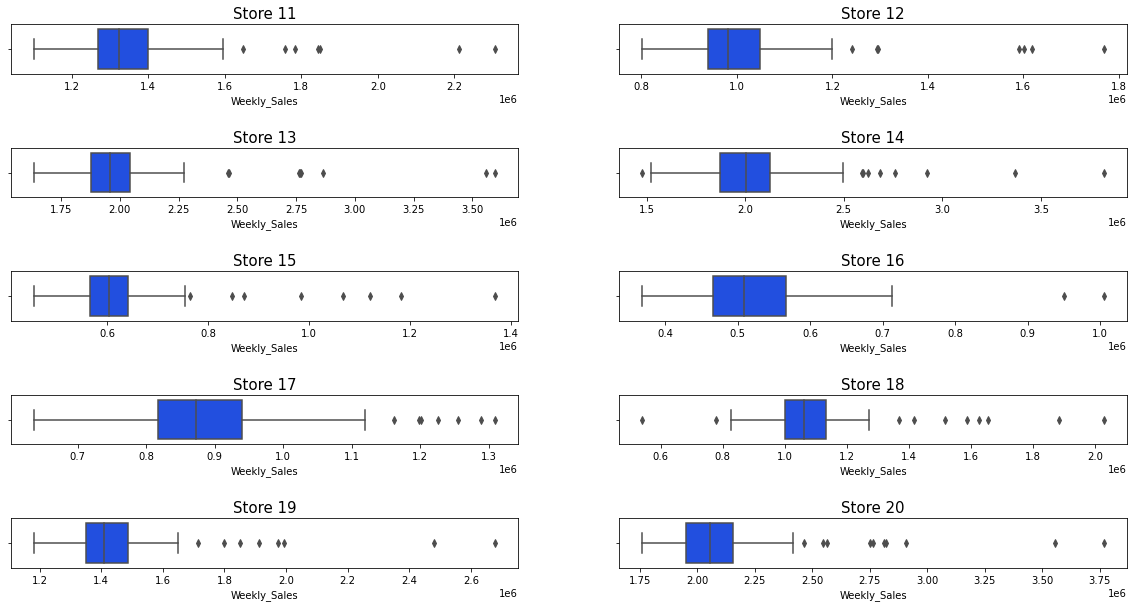

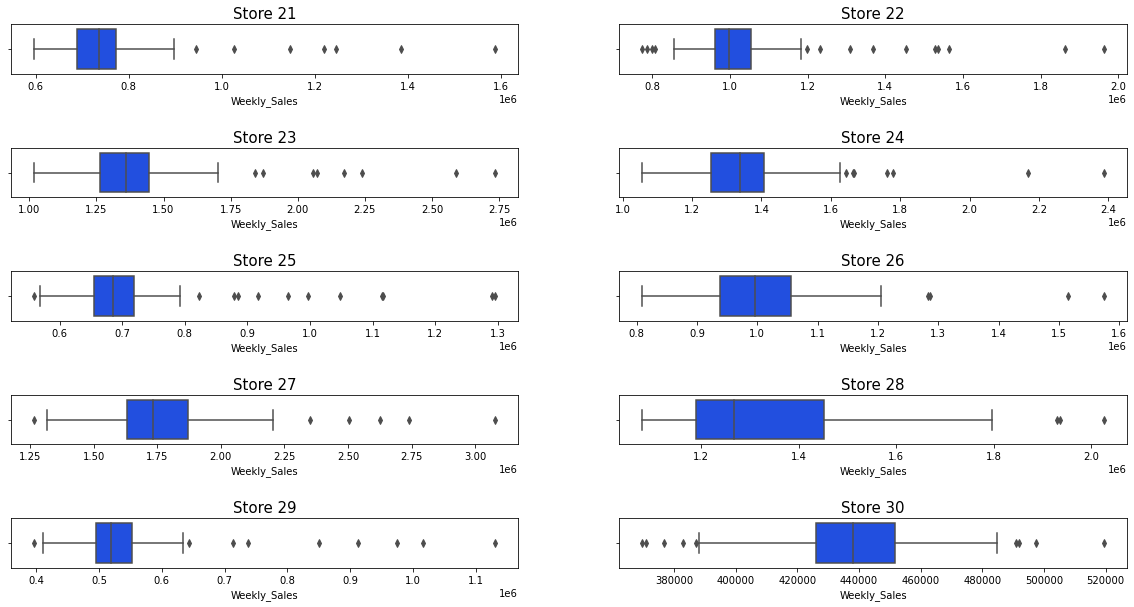

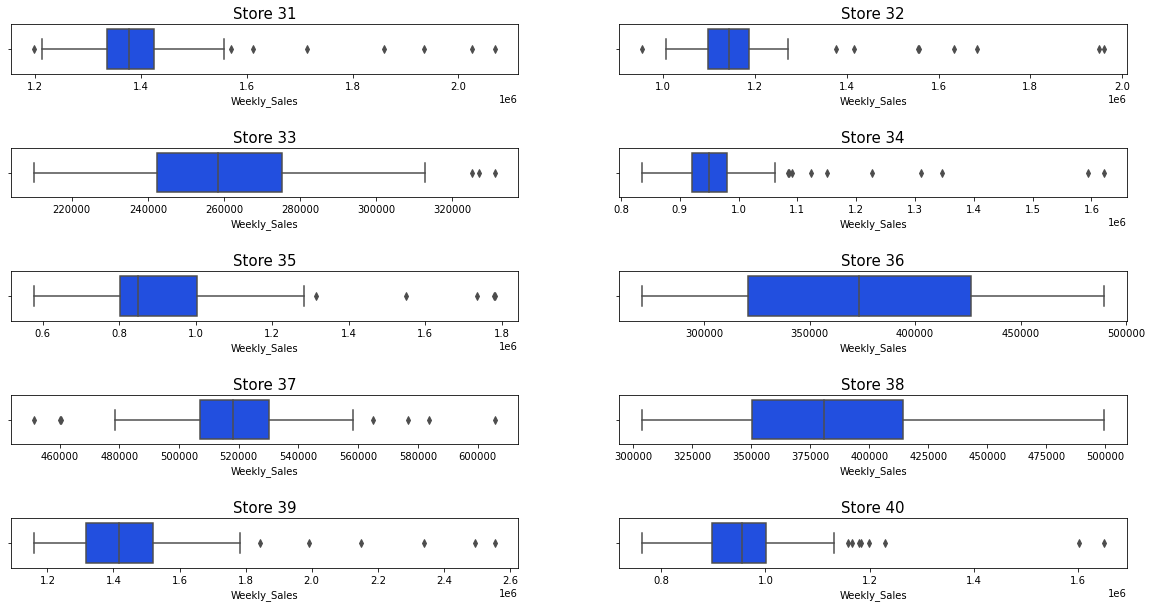

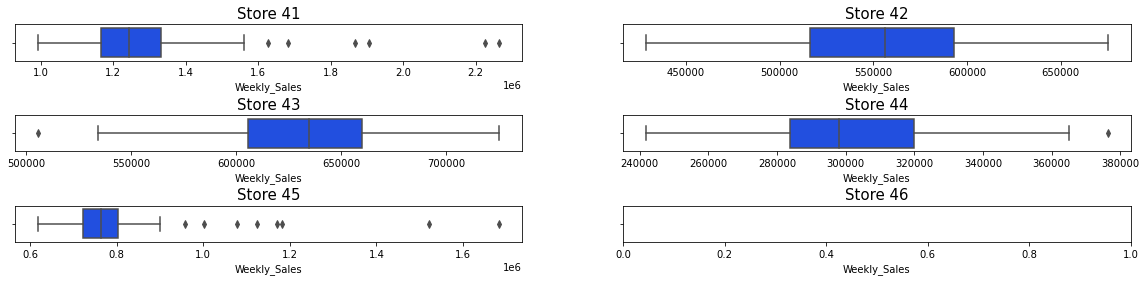

In [145]:
# box plot of weekly sales
outlier_plot(range(1,11))
outlier_plot(range(11,21))
outlier_plot(range(21,31))
outlier_plot(range(31,41))
outlier_plot(range(41,47), 3, 2, 20, 4)

Note that all store have outliersof weekly sales except store: 36, 42, 43, 44

### Distribution of each feature for different stores

In [146]:
# Distribution of weekly_sales over categorical feature (say Holiday_Flag) range
def get_sales_over_range_of_a_categorical_feature(minimum, maximum, sales_data, feature_name):
    sales_data = sales_data.groupby(feature_name)
    return sales_data

In [147]:
def get_the_bins(store_number, feature):
    sales_data=sales[sales['Store']==store_number]
    # dividing into 5 parts
    sales_quantile = sales[feature].quantile([0,0.2,0.4,0.6,0.8,1.0])
    result=[]
    for i in range(0,len(sales_quantile.index)):
        quantile = sales_quantile.index[i]
#         next_quantile = sales_quantile.index[i+1]
#         length = len(sales_data[(sales_data[feature]>=sales_quantile[quantile])&(sales_data[feature]<=sales_quantile[next_quantile])])
        
        result.append(round(sales_quantile[quantile],1))
    return result

In [148]:
# Distribution of weekly_sales over different feature (say temperature) range
# getting sum of sales is better, because a given temperature range, might have more or less frequency
def get_sales_over_range_of_a_feature(minimum, maximum, sales_data, feature_name):
#     feature_in_bins = np.round(np.linspace(minimum, maximum, 10),1)
    feature_in_bins = get_the_bins(store_number, feature_name)
    feature_value_range = pd.cut(sales_data[feature_name], bins=feature_in_bins)
    sales_data = sales_data.groupby(feature_value_range)
    return sales_data

In [149]:
def plot_sales_over_range_of_a_feature(is_categorical, sales_data, store_number, plot_count, feature_name, axis):
    #use subplot
    plot_rows=plot_count
    sns.set(font_scale=1.5)

    # Aggregate weekly_Sales over features 
    sales_data_aggregate=sales_data.sum('Weekly_Sales')
    sns.barplot(x=sales_data_aggregate.index, y=sales_data_aggregate['Weekly_Sales'], ax=axis[plot_rows])
    axis[plot_rows].set_title('Aggregate Weekly_Sales vs '+feature_name+' for Store '+str(store_number))
    axis[plot_rows].set_xlabel(feature_name+' range', fontsize=12)
    axis[plot_rows].set_ylabel('Weekly sales', fontsize=12)
    


In [150]:
def get_min_max_of_feature(feature_name):
    minimum = min(sales[feature_name])
    maximum = max(sales[feature_name])
    return (minimum,maximum)

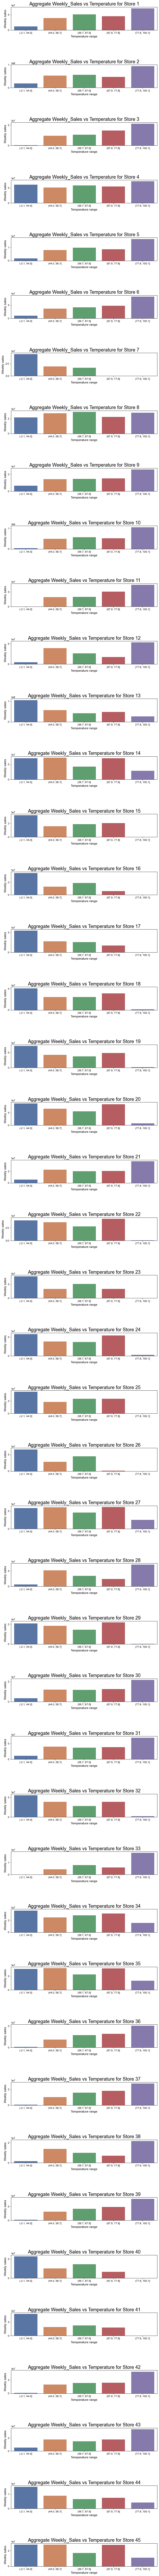

In [151]:
# Get one feature like temperature
feature_names=['Temperature']
stores=sales.groupby('Store').sum().index
for feature_name in feature_names:
    plot_count=0
    # subplots for predicted_sales and forecasted_sale
    fig, axis = plt.subplots(len(stores),1, figsize=(10,180))
    fig.subplots_adjust(hspace=1.5)
    # getting min and max values for entire sales data, to make range uniform across different stores
    (minimum, maximum) = get_min_max_of_feature(feature_name)
    for store_number in stores:
        sales_data = sales[sales['Store']==store_number]
        if feature_name!='Holiday_Flag':
            sales_data = get_sales_over_range_of_a_feature(minimum, maximum, sales_data, feature_name)
            plot_sales_over_range_of_a_feature(False, sales_data, store_number, plot_count, feature_name, axis)
            
        else:
            sales_data = get_sales_over_range_of_a_categorical_feature(minimum, maximum, sales_data, feature_name)
            plot_sales_over_range_of_a_feature(True, sales_data, store_number, plot_count, feature_name, axis)

        fig.savefig(feature_name+'.jpeg')
        plot_count+=1
        


## Designing a Machine_learning model for forecasting of Sales_data of different stores

### Model Selection

#### Plot the weekly_sales against time for selected stores

In [152]:
def plot_predicted_data(sales_to_plot, store_number, plot_count, ax_predict):
    # setting axis for plot
    plot_rows= plot_count//3
    if plot_count%3==0:
        plot_columns = 0
    elif plot_count%3==1:
        plot_columns = 1
    else:
        plot_columns = 2
    
    ax_predict[plot_rows, plot_columns].set_title('Weekly_Sales for Store '+str(store_number))
    ax_predict[plot_rows, plot_columns].set_xlabel('Dates')
    ax_predict[plot_rows, plot_columns].set_ylabel('Weekly_Sales')
    sales_to_plot.plot(ax=ax_predict[plot_rows, plot_columns]);

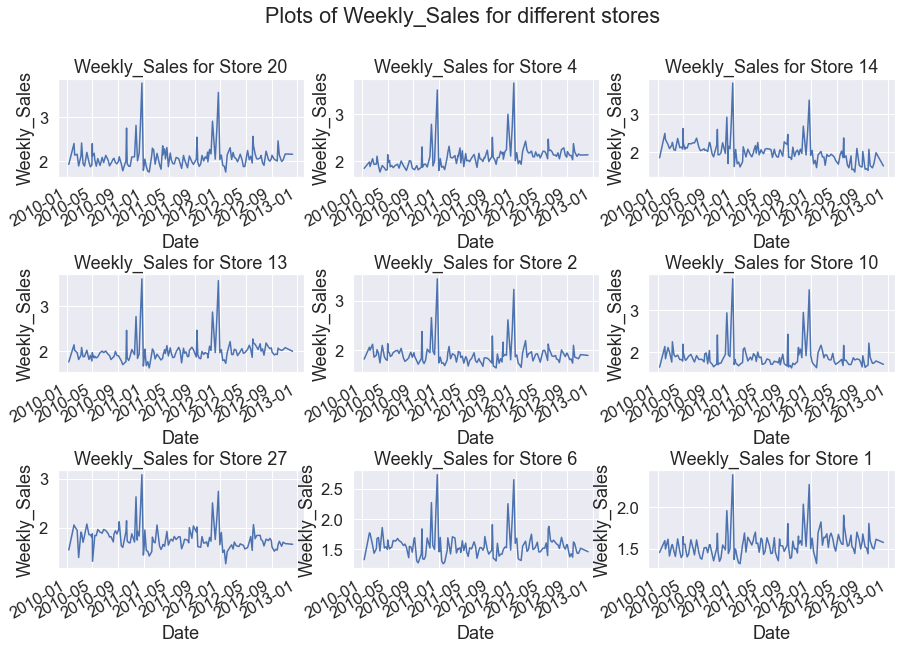

In [153]:
top_9_store_numbers=sales.groupby('Store').mean().sort_values(by='Weekly_Sales', ascending=False).iloc[0:9].index
# date_of_prediction = '2012-07-27'
number_of_weeks_to_forecast=12
plot_count=0
accuracy_results_for_store={}
# subplots for predicted_sales and forecasted_sales
fig_predict = plt.figure(figsize=(15,10))
ax_predict = fig_predict.subplots(len(top_9_store_numbers)//3,3)
fig_predict.suptitle('Plots of Weekly_Sales for different stores')
fig_predict.subplots_adjust(bottom=0.15, hspace=1.0)


for store_number in top_9_store_numbers:
    sales_to_plot = sales.set_index('Date')
    sales_to_plot = sales_to_plot[sales_to_plot['Store']==store_number]['Weekly_Sales']/1e6

    plot_predicted_data(sales_to_plot, store_number, plot_count, ax_predict)
    plot_count+=1

*Here we see the Weekly_sales as stationary with respect to Dates, However we would check the stationarity of each store in the TimeSeries modelling*

### Approach of each model

**It was decided to do predcitions for each store separately, Becasue the correlation of each feature is different for different stores**

Here we take for top 6 stores for our inferecing the forecasting of the sales

*We are taking 2 types of models, for forecasting our sales_data:*
1. TimeSeries (ARIMA) model:
    - The first step for this model is to check the stationarity of the dataset (p-value <0.05 adfuller test)
    - Next is to find the best ARIMA order for the model
    - Using the best ARIMA order, make predictions for the selected stores.
    - Forecast using SERIMAX
        - Detrend the dataset, if necessary ( remove trend by subtracting)
        - Using SERIMAX estimate for 12 weeks (weekly_sales)

2. Regression Models:
    - Regression Model, Gradient_Boosting, LinearRegression and Random_Forest were also used for the precition. The best of the three predictions by ARIMA mdel predictions.
    
    

### Procedure Extracting Results from the model
**1. For ARIMA**

a) Prediciton
For top 6 stores(20, 4, 13, 2, 10, 27) 
- Fit the sales_data of different stores
- plot the graph for weekly Sales vs Date
- Get the Median Error % and mean Error %

b) Forecast (For next 12 weeks)

**2. Regression Model**

a) Prediciton
For top 6 stores(20, 4, 13, 2, 10, 27) 

line plot of Prediction and actual (Weekly_Sales vs Date) 
- Gradient_Boosting
- Linear Regression
- Random_Forest

Also get the accuracy result
Max_Error %, Min_Error %, Mean_Error %, Median_Error %  , For the following
- Gradient_Boosting
- Linear Regression
- Random_Forest

Also get the r2, ad_r2, rmse (Root mean squar error) (on train and test) , mape (mean_absolute % error) (on train and test)
- Gradient_Boosting
- Linear Regression
- Random_Forest

b) Forecast (Here forecast is already done by ARIMA for 6 different stores), and It is always recommended to forecast using Timeseries, we just used Regresssion to see the accuracy of the model.


### SARIMAX Time Series

In [154]:
def removing_trend(sales_data):
    #removing trend using the rolling mean differencing 

    rolling_mean = sales_data.rolling(window=12).mean()

    #Rolling means creating a rolling window with a specified size and perform calculations on the data in this window which, of course, rolls through the data.

    #Rolling averages are useful for finding long-term trends otherwise disguised by occasional fluctuations. 
    rolling_mean_detrended = sales_data - rolling_mean

    return rolling_mean_detrended

In [155]:
def removing_seasoality(rolling_mean_detrended):
    #removing seasonality from the time series
    rolling_mean_detrended_diff = rolling_mean_detrended - rolling_mean_detrended.shift()
    return rolling_mean_detrended_diff

In [156]:
def store_get_sales_data_for_store(store_number, number_of_weeks_to_forecast):

    sales_data=sales[sales['Store']==store_number]
    sales_data.reset_index(inplace=True)
    sales_data.drop(columns=['Year', 'Month', 'Month_name', 'Week', 'Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment'], inplace=True)
    # arrange in ascending order of Dates
    sales_data.sort_values('Date',inplace=True)
    sales_data.reset_index(inplace=True)

    # add future dates
    future_dates = pd.DataFrame({'Date': pd.date_range(start=sales_data['Date'].iloc[-1], periods= number_of_weeks_to_forecast, freq='w', closed='right')})
    sales_data=pd.concat([sales_data, future_dates], ignore_index=True)
    
    # getting only required columns
    sales_data = sales_data[['Date', 'Weekly_Sales']]

    return sales_data

In [157]:
def is_stationary(sales_data):
    result = adfuller(sales_data['Weekly_Sales'].dropna())
    if result[1]>0.05:
        print('not stationary')
        return False
    else:
        print('stationary')
        return True

In [158]:
def get_best_order_of_ARIMA(sales_data):
    order = auto_arima(sales_data['Weekly_Sales'].dropna())
    results_summary = order.summary()

    #converting the summary into DataFrame to get the order
    results_as_html = results_summary.tables[0].as_html()
    result_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
    order_value = result_df.loc['Model:','y']
    order_value = order_value.replace('SARIMAX','')
    order_value = [int(s) for s in order_value if s.isdigit()]
    return order_value

In [159]:
def fit_data_into_model(sales_data, order):
    p,q,r=[x for x in order_value]
    model = ARIMA(sales_data['Weekly_Sales'], order=(p,q,r))
    model_result = model.fit()
    return model_result

In [160]:
def predict_sales_data(sales_data, model_result):
    
    training_data_length = len(sales_data)*80//100
    start = training_data_length
    end = len(sales_data)-1
    sales_data['Predicted Weekly_Sales'] = model_result.predict(start = start, end = end, dynamic=False);
    
    # getting only those data which are used for rediction
    sales_data.dropna(inplace=True)
    return sales_data
        

In [161]:
def calculate_error_percentage(sales_data_for_vaidation):
    
    #Removing first predicted sales, as usually SARIMAX will predict 0 for the first date
    if (sales_data_for_vaidation.iloc[0]['Predicted Weekly_Sales']==0):
        sales_data_for_vaidation = sales_data_for_vaidation.iloc[1:]
        
    y_test = sales_data_for_vaidation['Weekly_Sales']
    y_pred = sales_data_for_vaidation['Predicted Weekly_Sales']
    abs_errors_list=(np.abs(np.subtract(y_pred, y_test))/y_test)
    accuracy_results={}
    # mean error (%)
    accuracy_results['mean error (%)']=np.mean(abs_errors_list) * 100
    # median error (%)
    accuracy_results['median error (%)']=np.median(abs_errors_list) * 100
    #max Errror (%)
    accuracy_results['max error (%)']=np.max(abs_errors_list)*100
    #min Errror (%)
    accuracy_results['min error (%)']=np.min(abs_errors_list)*100
    # accuracy_results_for_model[model_name]=accuracy_results
    
    return accuracy_results

In [162]:
def plot_predicted_data(sales_data, store_number, plot_count, ax_predict):
    # setting axis for plot
    plot_rows= plot_count//2
    plot_columns = 0 if plot_count%2==0 else 1
    
    # Resetting date as index
    sales_data_for_plot = sales_data.set_index('Date')
    
    ax_predict[plot_rows, plot_columns].set_title('ARIMA predicted plot for Store '+str(store_number))
    ax_predict[plot_rows, plot_columns].set_xlabel('Dates')
    ax_predict[plot_rows, plot_columns].set_ylabel('Weekly_Sales')
    sales_data_for_plot[['Weekly_Sales', 'Predicted Weekly_Sales']].plot(ax=ax_predict[plot_rows, plot_columns]);
    

In [163]:
def forecast_sales_data(number_of_weeks_to_Forecast, model_result):
    forecast_data = model_result.forecast(steps = number_of_weeks_to_Forecast)
    return forecast_data

In [164]:
def plot_forecasted_data(forecast_data, forecast_sales_data_dates, store_number, plot_count, ax_forecast):
    #setting axis for plot
    plot_rows= plot_count//2
    plot_columns = 0 if plot_count%2==0 else 1
    
    
    # Resetting date as index
    forecast_data.index=forecast_sales_data_dates['Date']
    
    ax_forecast[plot_rows, plot_columns].set_title('ARIMA Forecast plot for Store '+str(store_number))
    ax_forecast[plot_rows, plot_columns].set_xlabel('Dates')
    ax_forecast[plot_rows, plot_columns].set_ylabel('Weekly_Sales')
    forecast_data.plot(ax=ax_forecast[plot_rows, plot_columns]);
    


In [165]:
def forecasting_sales_data_into_ARIMA(sales_data, forecast_sales_data_dates, store_number, plot_count, 
                                       ax_predict, ax_forecast, number_of_weeks_to_forecast):
    # Getting the best order for ARIMA model
    print('getting best order for ARIMA model')
    order = get_best_order_of_ARIMA(sales_data)

    # Fit the SERIMAX model and predict the outcome
    print('Fitting Sales_data for ARIMA model')
    model_result = fit_data_into_model(sales_data, order)

    print('Predicting best order for ARIMA model')
    # Predicting the sales and testing its accracy
    sales_data = predict_sales_data(sales_data, model_result)
    plot_predicted_data(sales_data, store_number, plot_count, ax_predict)
    #Use mape later by collecting into a list
    accuracy_results = calculate_error_percentage(sales_data)
    # Forecast for 12 weeks
    forecasted_data = forecast_sales_data(number_of_weeks_to_forecast, model_result)
    # plot for 12 weeks
    plot_forecasted_data(forecasted_data, forecast_sales_data_dates, store_number, plot_count, ax_forecast)
    
    return accuracy_results


For store number:  20
stationary
getting best order for ARIMA model
Fitting Sales_data for ARIMA model


NameError: name 'order_value' is not defined

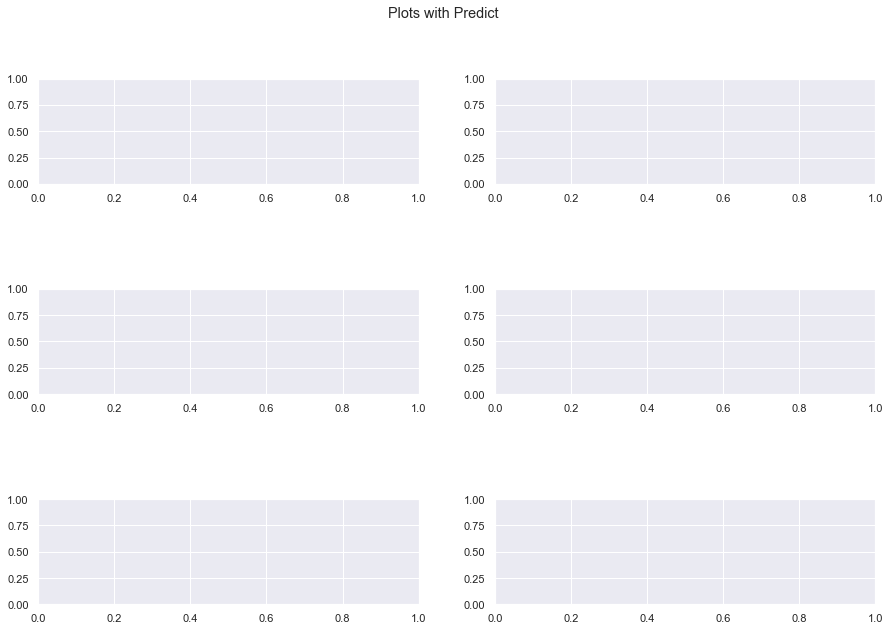

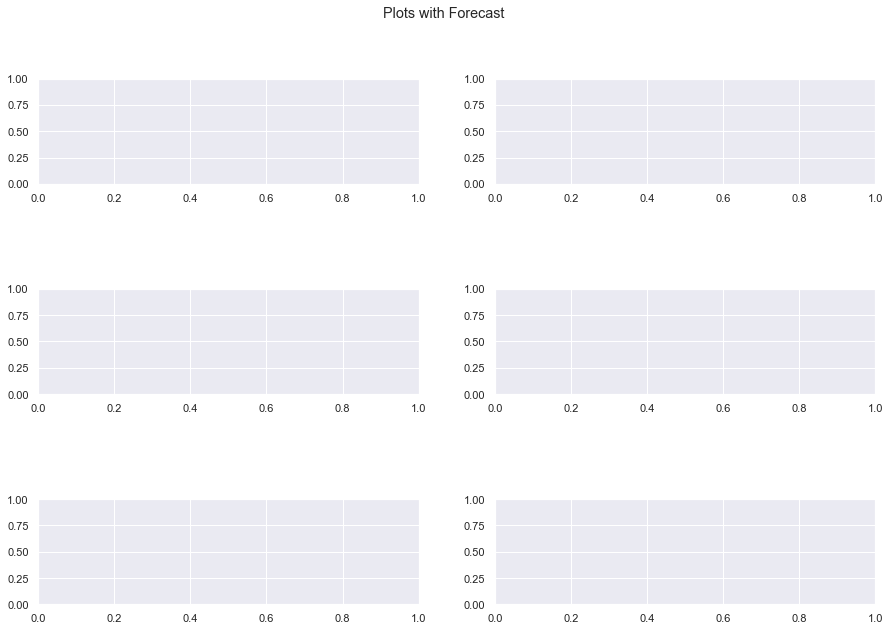

In [166]:
top_6_store_numbers=[20, 4, 13, 2, 10, 27]
sns.set(font_scale=1.0)
number_of_weeks_to_forecast=12
plot_count=0
accuracy_results_for_store={}
# subplots for predicted_sales and forecasted_sales
fig_predict = plt.figure(figsize=(15,10))
fig_forecast = plt.figure(figsize=(15,10))
ax_predict = fig_predict.subplots(len(top_6_store_numbers)//2,2)
ax_forecast = fig_forecast.subplots(len(top_6_store_numbers)//2,2)
fig_predict.suptitle('Plots with Predict')
fig_forecast.suptitle('Plots with Forecast')
fig_predict.subplots_adjust(bottom=0.15, hspace=1.0)
fig_forecast.subplots_adjust(bottom=0.15, hspace=1.0)


for store_number in top_6_store_numbers:    
    print('For store number: ', store_number)
    # Getting the data
    sales_data = store_get_sales_data_for_store(store_number, number_of_weeks_to_forecast)
    forecast_sales_data_dates = sales_data[sales_data['Weekly_Sales'].isna()]
    sales_data = sales_data.dropna()
    # checking the stationarity of the data
    stationarity = is_stationary(sales_data)
    #If non-stationary then convert to stationary
    if(stationarity):
        accuracy_results=forecasting_sales_data_into_ARIMA(sales_data, forecast_sales_data_dates, store_number, 
                                                           plot_count, ax_predict, ax_forecast, number_of_weeks_to_forecast)
    else:
        # Getting only 'Weekly_sales' for de-trend
        sales_data=sales_data[['Weekly_Sales']]
        # convert into stationary
        detrended_sales_data = removing_trend(sales_data)
        # detrended_sales_data = removing_seasoality(rolling_mean_detrended)
        # check for stationary
        detrended_sales_data.dropna(inplace=True)
        stationarity = is_stationary(detrended_sales_data)
        accuracy_results=forecasting_sales_data_into_ARIMA(detrended_sales_data, forecast_sales_data_dates, store_number, 
                                                           plot_count, ax_predict, ax_forecast, number_of_weeks_to_forecast)
    accuracy_results_for_store['Store_'+str(store_number)]=accuracy_results
    plot_count+=1
    print('End of store number: ', store_number)

# print accuracy result
result=pd.DataFrame().from_dict(accuracy_results_for_store)
print(result)
result

### Conclusion
Each store is trained in ARIMA model, and predictions are made for 20% of the sales_data as well as the accuracy of the model for each store is calculated. Further more, predctions are alos being made for next 12 weeks.

## Using Regression model 

For now we are using 3 regression machine-learning models 
- Linear Regression
- Gradient Boosting
- Random Forest 
And checking the accuracy of the each models for different stores

In our regression model we take input as the historic sales_data and output as current sales_data

In [ ]:
def store_get_sales_data_for_store_for_regression(store_number):

    sales_data=sales[sales['Store']==store_number]
    sales_data.drop(columns=['Year', 'Month', 'Month_name', 'Week', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment'], inplace=True)
    #arrange in ascending order of Dates
    sales_data.sort_values('Date',inplace=True)
    sales_data.set_index('Date', inplace=True)

    # In supervised learning the input data will have past sales, and output will be the sales_value based on the past sales  
    # Here we take Sales of last week, Sales of last 2 weeks and Sales of last 3 weeks 
    sales_data['Sales_LastWeek'] = sales_data['Weekly_Sales'].shift(1)
    sales_data['Sales_2WeekBack'] = sales_data['Weekly_Sales'].shift(2)
    sales_data['Sales_3WeekBack'] = sales_data['Weekly_Sales'].shift(3)
    sales_data.dropna(inplace=True)

    return sales_data

In [ ]:
def extract_variables_from_store_sales(sales_data):
    # Note: x and y are index-less (ie) they dont have index as dates, while training into Supervised-learning

    x1,x2,x3,y = sales_data['Sales_LastWeek'], sales_data['Sales_2WeekBack'], sales_data['Sales_3WeekBack'], sales_data['Weekly_Sales']
    x1,x2,x3,y = np.array(x1), np.array(x2), np.array(x3), np.array(y)
    x1,x2,x3,y = x1.reshape(-1,1), x2.reshape(-1,1), x3.reshape(-1,1), y.reshape(-1,1)
    final_x = np.concatenate((x1,x2,x3), axis=1)
    # splitting 80% of data as train-data and remaining as test data
    train_data_lenght = len(final_x)*(80)//100
    x_train, x_test, y_train, y_test = final_x[:train_data_lenght], final_x[train_data_lenght:], y[:train_data_lenght], y[train_data_lenght:]
    
    return [x_train, x_test, y_train, y_test]

In [ ]:
def prepare_model(model_name, variables):
    # Creating the Regression model
    model=None
    if (model_name == 'Linear_Regression'):
        model = LinearRegression()
    elif (model_name == 'Random_Forest'):
        model = RandomForestRegressor()
    elif (model_name == 'Gradient_Boosting'):
        model = GradientBoostingRegressor()
    else :
        print('no model')
    
    x_train=variables[0] 
    y_train=variables[2]
    # fitting the training_data into the model
    model.fit(x_train, y_train)
    return model

In [ ]:
def predict_sales(model, variables, for_testing_data):
    # Removing y_pred for previous_model and add new y_pred for current_model
    if (len(variables)>4):
        variables.pop()
    
    if(for_testing_data):
        # getting x_test data and using that to predict the sales_data 
        x_test = variables[1]
    else:
        # getting x_train data and using that to predict the sales_data 
        x_test = variables[0]
        
    y_pred = model.predict(x_test)
    variables.append(y_pred)
    
    return variables

In [ ]:
def plotting_predicted_sales(sales_data, model_name, store_number, plot_count, variables):
    #plot the graph (actual vs predicted)

    #setting axis for plot
    plot_rows=len(top_6_store_numbers)
    plot_columns=3
    
    ax = plt.subplot(plot_rows, plot_columns, plot_count)
    plt.subplots_adjust(bottom=0.15, hspace=1.5, left = 0.05)
    y_test = variables[3]
    y_pred = variables[4]
    
    # resetting the index to dates
    y_test_plot = y_test.reshape(1,-1)[0]
    y_test_plot = sales_data[sales_data['Weekly_Sales'].isin(y_test_plot)]['Weekly_Sales']
    y_pred_plot = y_pred.reshape(1,-1)[0]
    y_pred_plot = pd.Series(data=y_pred_plot, index= y_test_plot.index)
    
    # Scaling the y-axis
    y_test_plot = y_test_plot/1e6
    y_pred_plot = y_pred_plot/1e6
    
    # Plotting sales
    y_test_plot.plot(c='green', alpha=0.6, ax=ax, figsize=(15,18), label='Actual')
    y_pred_plot.plot(c='orange', alpha=1, ax=ax, figsize=(15,18), label='Predicted')
    plt.title(model_name+' predicted plot for Store '+str(store_number))
    plt.legend(loc = 'upper right');
    plt.xlabel('Dates')
    plt.ylabel('Weekly_Sales')
    plt.legend()
    

In [ ]:
def calculate_error_percentage(model_name, variables):
    y_test=variables[3]
    y_pred=variables[4]
    abs_errors_list=(np.abs(np.subtract(y_pred, y_test))/y_test)
    accuracy_results={}
    # mean error (%)
    accuracy_results['mean error (%)']=np.mean(abs_errors_list) * 100
    # median error (%)
    accuracy_results['median error (%)']=np.median(abs_errors_list) * 100
    #max Errror (%)
    accuracy_results['max error (%)']=np.max(abs_errors_list)*100
    #min Errror (%)
    accuracy_results['min error (%)']=np.min(abs_errors_list)*100
    # accuracy_results_for_model[model_name]=accuracy_results
    
    return model_name,accuracy_results

In [ ]:
# r2_on_test, r2_on_train, rmse_on_test, rmse_on_train, mape_on_test, mape_on_train
def calculate_accuracy(model_name, variables, for_testing_data):
    accuracy_results={}
    if (for_testing_data):
        y_actual=variables[3]
        rmse_index='rmse_on_test'
        mape_index='mape_on_test'
        r2_index='r2_on_test'
    else:
        y_actual=variables[2]
        rmse_index='rmse_on_train'
        mape_index='mape_on_train'
        r2_index='r2_on_train'
    y_pred=variables[4]
    
    # root_mean_square_error
    accuracy_results[rmse_index]=(mean_squared_error(y_pred,y_actual)**(0.5))
    # mean absolute percentage error
    accuracy_results[mape_index]=mean_absolute_percentage_error(y_pred,y_actual)
    # coefficient of determination
    accuracy_results[r2_index]=r2_score(y_pred,y_actual)
    
    return model_name,accuracy_results

In [ ]:
def print_accuracy_results(accuracy_results_for_store):
    for store_number,accuray_results_for_models in accuracy_results_for_store.items():
        model_data_frame=pd.DataFrame()
        print('Store Number {} Evaluation Report: '.format(store_number))
        print(pd.DataFrame().from_dict(accuray_results_for_models))
        print('=============================================================================')

In [ ]:
model_names = ['Linear_Regression', 'Random_Forest', 'Gradient_Boosting']
top_6_store_numbers=[20, 4, 13, 2, 10, 27]
# model_names = ['Gradient_Boosting']
# top_6_store_numbers=[20]
plot_count=1
perc_error_results_for_store, accuracy_results_for_store={},{}
#Iterate over each store for every model
for store_number in top_6_store_numbers:
    variables=[]
    perc_error_results_for_model, accuracy_results_for_model={},{}
    print('for store ',store_number)
    # Getting the data
    sales_data = store_get_sales_data_for_store_for_regression(store_number)
    variables = extract_variables_from_store_sales(sales_data)
    for model_name in model_names:
        print('for model_name', model_name, ' store_number ',store_number)
        # Preparing the models
        model = prepare_model(model_name, variables)
        # Forcasting for given dates for test-data
        variables = predict_sales(model, variables, True)
        #plotting the forcasted data
        plotting_predicted_sales(sales_data, model_name, store_number, plot_count, variables)
        plot_count+=1
        
        #calculating the percentage error
        perc_error_results = calculate_error_percentage(model_name, variables)
        perc_error_results_for_model[perc_error_results[0]]=perc_error_results[1]
        
        # calculating the accuracy
        
        # Forcasting for given dates for train-data
        variables = predict_sales(model, variables, True)
        # calculating  the accuracy for test data
        accuracy_results = calculate_accuracy(model_name, variables, True)
        test_accuracy_result=accuracy_results[1]
        
        # Forcasting for given dates for train-data
        variables = predict_sales(model, variables, False)
        # calculating  the accuracy for train data
        accuracy_results = calculate_accuracy(model_name, variables, False)
        train_accuracy_result=accuracy_results[1]
        
        # Appending the accuracy of train and test for different models for a given store
        accuracy_results_for_model[accuracy_results[0]]=train_accuracy_result|test_accuracy_result
        
        
    # Gathering the % error, and accruacy-score for different stores in a list
    perc_error_results_for_store[store_number]=perc_error_results_for_model
    accuracy_results_for_store[store_number]=accuracy_results_for_model
# getting percentage_error_results
print('Percentage errors')
print_accuracy_results(perc_error_results_for_store)
# getting accuracy_results
print('\n\n\n')
print('Accuracy scores')
print_accuracy_results(accuracy_results_for_store)
print('NOTE:')
print('r2: R2-Score')
print('rmse: Root Mean Square Error')
print('mape: Mean Absolute Percentage Error')

**Conclusion after predicting sales for different stores using regression models:**
 
Over all the stores, Gradient Boosting is the best model to be used for the current sales data. 